In [84]:
import numpy as np
import json
import os
import sys
import matplotlib.pyplot as plt
#import scienceplots  # optional, requires latex
#plt.style.use(['science', 'grid'])

# set matplotlib font size
plt.rcParams.update({
    "font.size": 12,         # Default font size for all text
    "axes.labelsize": 9,    # X and Y label font size
    "xtick.labelsize": 9,   # X-axis tick label font size
    "ytick.labelsize": 9,   # Y-axis tick label font size
    "legend.fontsize": 9,   # Legend font size
})

# Import plotting utility functions
sys.path.append('../')
from plot_util import (init_metrics, update_metrics, init_variables, update_variables,
                       plot_field, plot_field_residual, plot_field_columns, make_formatter, subsample_steps,
                        animate_frame, moving_average, moving_min)


In [85]:
from scipy.stats import trim_mean

# Select run to plot
# noise = 1
results_folder = f"results/real_world_strain_E200nu60/"

measurments_type = ["displacement","strain"][1]
# iteration = 40000
time = 3

# camera_id = 0
# camera_resolutions = ["5MP","2MP","0.4MP"]
# camera_npoints = ['192x191', '115x114', '41x39']
# camera_resolution = camera_resolutions[camera_id]
# camera_npoint = camera_npoints[camera_id]

# dic_prefix = 'dic_' 

smoothing = None # None, "min", "average"
window_size = 10

run = f"dic_strain_x11954_DIC_data_3min"


def get_folder_list(run, results_folder="./results/"):
    folder_list = []
    for folder_name in os.listdir(results_folder):
        if folder_name.startswith(run) and os.path.isfile(os.path.join(results_folder, folder_name, "config.json")):
            folder_list.append(results_folder+folder_name)
    return folder_list


def read_data_file(filename):
    with open(filename, "r") as f:
        # Read the file and split each line
        steps = []
        values = []
        for line in f.readlines():
            step, value = line.strip().split(' ',1)
            steps.append(eval(step))
            values.append(eval(value))
    return steps, values


def load_runs(folder_list, window_size=10, smoothing=None):
    loss_history = []
    variables_history = []
    for folder in folder_list:
        loss_hist = np.loadtxt(folder + "/loss_history.dat")
        if smoothing == "min":
            loss_hist = moving_min(loss_hist, window_size)
        elif smoothing == "average":
            loss_hist = moving_average(loss_hist, window_size)
        loss_history.append(loss_hist)
        variables_history.append(read_data_file(folder + "/variables_history.dat"))

    steps_min = min(loss_hist.shape[0] for loss_hist in loss_history)
    loss_history = np.array([loss_hist[:steps_min] for loss_hist in loss_history])
    E_history = np.array([np.array(variables_hist[1])[:steps_min,0] for variables_hist in variables_history])
    nu_history = np.array([np.array(variables_hist[1])[:steps_min,1] for variables_hist in variables_history])

    return loss_history, E_history, nu_history

folder_list = get_folder_list(run, results_folder=results_folder)
print(f"{len(folder_list)} runs for {run}")

with open(folder_list[0] + "/config.json") as f:
    run_config = json.load(f)


loss_history, E_history, nu_history = load_runs(folder_list, window_size=window_size, smoothing=smoothing)
E_history /= 1e3 # N/m^2 -> GPa

steps_loaded = loss_history[0,:, 0] 
residuals = loss_history[:,:, -1]
PDE_loss = np.mean(loss_history[:,:, 1:3], axis=2)
Mat_loss = np.mean(loss_history[:,:, 3:5], axis=2)
DIC_loss = np.mean(loss_history[:,:, 5:7], axis=2)
Total_loss = np.mean(loss_history[:,:, 1:7], axis=2)

metrics = [residuals, PDE_loss, Mat_loss, DIC_loss,Total_loss]
metrics_names = ["Rel. l2 error", "PDE Loss", "Material Loss", "DIC Loss","Total Loss"]

# Table of final values
E_init = run_config["problem"]["E_init"]/1e3 # 1e3 N/m^2 = 1 GPa
nu_init = run_config["problem"]["nu_init"]

E_actual = run_config["problem"]["E_actual"]/1e3 # GPa
nu_actual = run_config["problem"]["nu_actual"]

def get_trimmed_final_values(param_history, total_loss, loss_ratio=0.1, trim_ratio=0.2):
    final_values = []
    for param, loss in zip(param_history, total_loss):
        # Get the sorted indices based on loss (lower is better)
        sorted_idx = np.argsort(loss)
        # Select the top N indices (e.g., top 20%)
        N = int((1 - loss_ratio) * len(sorted_idx))
        best_idx = sorted_idx[:N]
        # Compute trimmed mean on best indices
        trimmed_val = trim_mean(param[best_idx], proportiontocut=trim_ratio)
        final_values.append(trimmed_val)
    return np.array(final_values)


# E_finals = np.array([np.mean(E[np.argsort(losses)[:5]]) for E, losses in zip(E_history, Total_loss)])
# nu_finals = np.array([np.mean(nu[np.argsort(losses)[:5]]) for nu, losses in zip(nu_history, Total_loss)])

E_finals = get_trimmed_final_values(E_history, Total_loss, loss_ratio=0.3, trim_ratio=0.3)
nu_finals = get_trimmed_final_values(nu_history, Total_loss, loss_ratio=0.3, trim_ratio=0.3)

print("-"*15*6) 
print(f"{'Parameter':<15}{'Initial':<15}{'Final (mean ± std)':<25}{'Reference':<15}{'Rel. Error':<25}")
print("-"*15*6)
print(f"{'E':<15}{E_init:<15.4f}{f'{np.mean(E_finals):.4f} ± {np.std(E_finals):.4f}':<25}{E_actual:<15.4f}{f'{np.mean(np.abs(E_finals - E_actual)/E_actual)*100:.4f} ± {np.std(np.abs(E_finals - E_actual)/E_actual)*100:.4f} %':<25}")
print(f"{'nu':<15}{nu_init:<15.4f}{f'{np.mean(nu_finals):.4f} ± {np.std(nu_finals):.4f}':<25}{nu_actual:<15.4f}{f'{np.mean(np.abs(nu_finals - nu_actual)/nu_actual)*100:.4f} ± {np.std(np.abs(nu_finals - nu_actual)/nu_actual)*100:.4f} %':<25}")



# print(E_history)
# print(E_history.std(axis=0)[-1])

10 runs for dic_strain_x11954_DIC_data_3min
------------------------------------------------------------------------------------------
Parameter      Initial        Final (mean ± std)       Reference      Rel. Error               
------------------------------------------------------------------------------------------
E              200.0000       131.6090 ± 0.0858        132.1353       0.3983 ± 0.0649 %        
nu             0.6000         0.3121 ± 0.0013          0.3120         0.3504 ± 0.2507 %        


In [18]:
# Save in json
noise_levels = [1e-06, 1e-05, 0.0001]
# Load the existing JSON file
if not os.path.exists("./results/summary.json"):
    with open("./results/summary.json", "w") as json_file:
        json.dump({}, json_file)

with open("./results/summary.json", "r") as json_file:
    json_data = json.load(json_file)

json_data["E_actual"] = E_actual
json_data["nu_actual"] = nu_actual
for noise in noise_levels:
    time = 5
    run = f"strain_x16_{noise}_5min"
    folder_list = get_folder_list(run, results_folder=results_folder)
    print(f"{len(folder_list)} runs for {run}")
    loss_history, E_history, nu_history = load_runs(folder_list, window_size=window_size, smoothing=smoothing)
    Total_loss = np.mean(loss_history[:,:, 1:7], axis=2)
    E_history /= 1e3 # N/m^2 -> GPa

    E_finals = get_trimmed_final_values(E_history, Total_loss, loss_ratio=0.2, trim_ratio=0.3)
    nu_finals = get_trimmed_final_values(nu_history, Total_loss, loss_ratio=0.2, trim_ratio=0.3)

    # if camera_resolution not in json_data:
    #     json_data[camera_resolution] = {}
    # if measurments_type not in json_data[camera_resolution]:
    #     json_data[camera_resolution][measurments_type] = {}

    json_data[noise]["strain"]["E"] = {"mean": np.mean(E_finals), "std": np.std(E_finals), "mean_rel_error": np.mean(np.abs(E_finals - E_actual)/E_actual)*100, "std_rel_error": np.std(np.abs(E_finals - E_actual)/E_actual)*100}
    json_data[noise]["strain"]["nu"] = {"mean": np.mean(nu_finals), "std": np.std(nu_finals), "mean_rel_error": np.mean(np.abs(nu_finals - nu_actual)/nu_actual)*100, "std_rel_error": np.std(np.abs(nu_finals - nu_actual)/nu_actual)*100}

with open("./results/summary.json", "w") as json_file:
    json.dump(json_data, json_file, indent=4)

0 runs for strain_x16_1e-06_5min


ValueError: min() iterable argument is empty

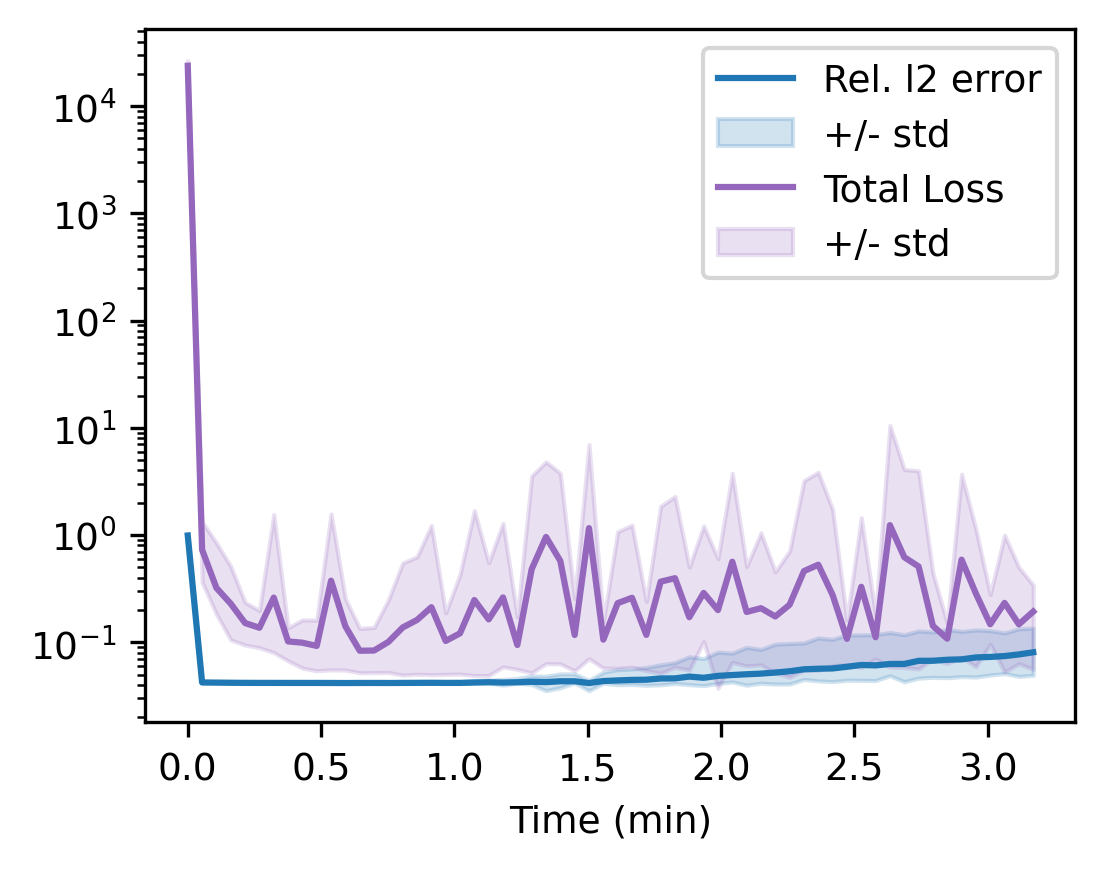

In [86]:
import matplotlib.pyplot as plt


step_type = ["iteration", "time"][1]
time_unit = ["s", "min"][1]
time_scaling = 1/60 if time_unit == "min" else 1
metrics_idx = [0,4]  # 0: residuals, 1: PDE loss, 2: Material loss, 3: DIC loss, 4: Total loss
t_elapsed = run_config["execution"]["elapsed"]
if step_type == "time":
    steps = np.array(steps_loaded) * t_elapsed / steps_loaded[-1] * time_scaling
else:
    steps = steps_loaded

palette = plt.get_cmap('tab10').colors

def init_metrics(ax, metrics_idx=[0]):
    ax.set_yscale('log')
    lines = []
    scatters = []
    for idx in metrics_idx:
        ax.plot(steps, metrics[idx].mean(axis=0), alpha=1, color=palette[idx])
        lines.append(ax.plot([], [], zorder=3, color=palette[idx], label=metrics_names[idx])[0])
        ax.fill_between(steps, metrics[idx].min(axis=0), metrics[idx].max(axis=0), alpha=0.2, color=palette[idx], label="+/- std")
        scatters.append(ax.scatter([], [], c='k', zorder=4))
    ax.legend()
    if step_type == "time":
        ax.set_xlabel(f"Time ({time_unit})")
    else:
        ax.set_xlabel("Iterations")
    return lines, scatters

def update_metrics(iterations, lines, scatters, metrics_idx=[0]):
    for line, scatter in zip(lines, scatters):
        for idx in metrics_idx:
            line.set_data(steps, metrics[idx][:iterations].mean(axis=0))
            scatter.set_offsets(np.array([steps[iterations], metrics[idx][:iterations].mean(axis=0)]).T)
    return lines, scatters


fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=300)
lines, scatters = init_metrics(ax,  metrics_idx=metrics_idx)
# update_metrics(-1, lines, scatters, metrics_idx=metrics_idx)
plt.show()

# anim = animation.FuncAnimation(fig, update_losshistory, fargs=(line_pinn, line_spinn, scatter_pinn, scatter_spinn), frames=int(len(losshistory_pinn)/10), interval=100, repeat=False)
# HTML(anim.to_jshtml())

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_244496/2315492605.py:4: SyntaxWarning: invalid escape sequence '\p'
  ax[0].plot(steps, E_history.mean(axis=0), color=palette[0], alpha=1, label=r"$E$"+f"={E_history.mean(axis=0)[-1]:.3f} $\pm$ {E_history.std(axis=0)[-1]:.3f}")
/tmp/ipykernel_244496/2315492605.py:5: SyntaxWarning: invalid escape sequence '\p'
  ax[1].plot(steps, nu_history.mean(axis=0), color=palette[1], alpha=1, label=r"$\nu$"+f"={nu_history.min(axis=0)[-1]:.3f} $\pm$ {nu_history.std(axis=0)[-1]:.4f}")


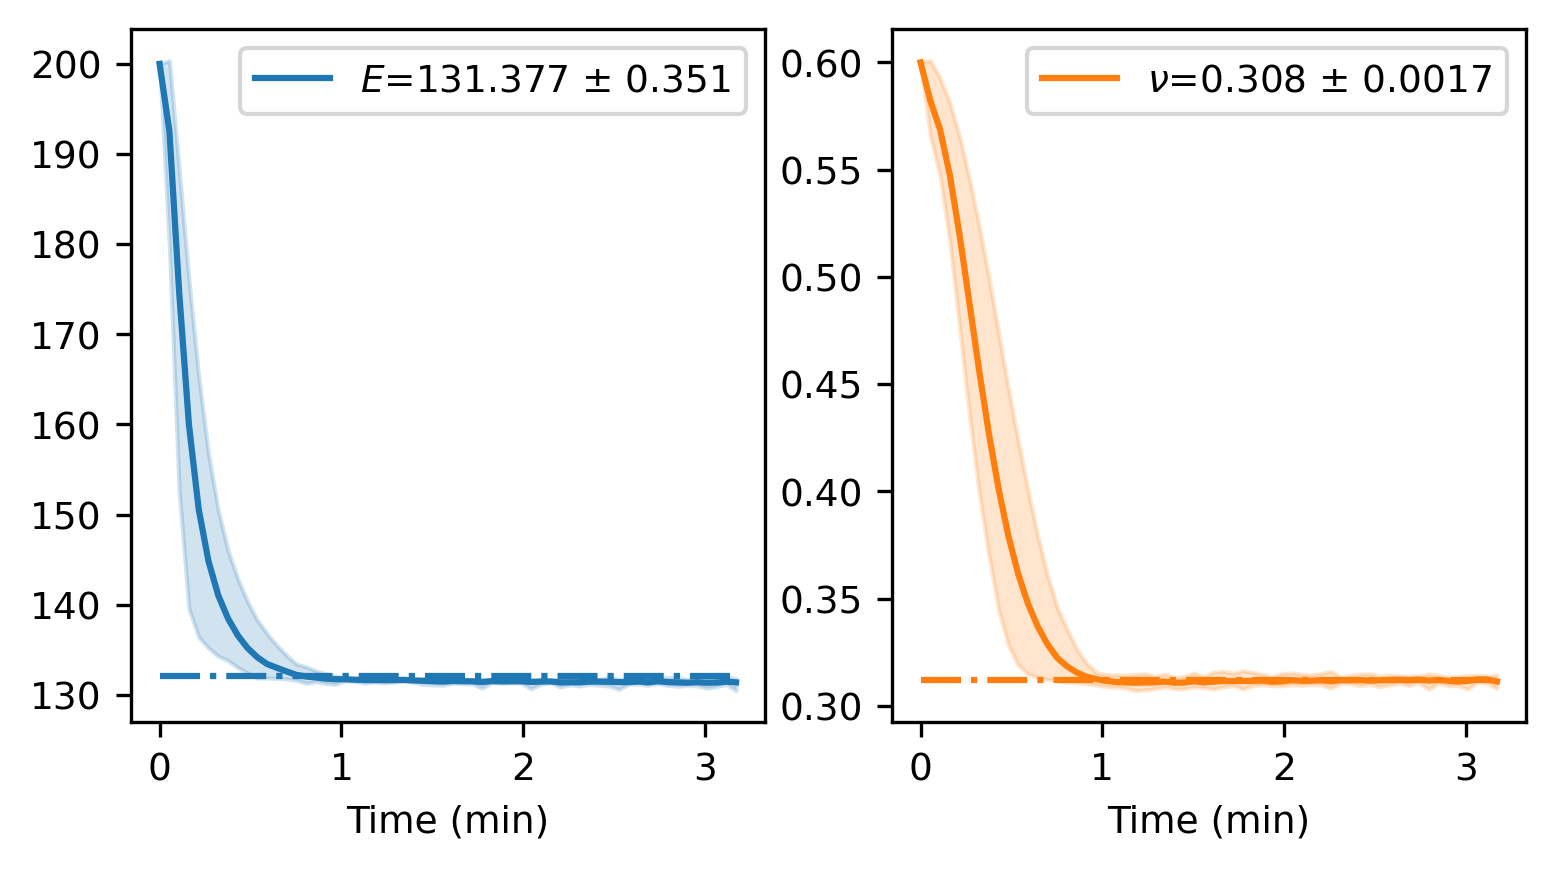

In [87]:
def init_variables(ax):
    ax[0].hlines(y=E_actual, xmin=0, xmax=steps.max(), linestyles='-.', colors=palette[0])
    ax[1].hlines(y=nu_actual, xmin=0, xmax=steps.max(), linestyles='-.', colors=palette[1])
    ax[0].plot(steps, E_history.mean(axis=0), color=palette[0], alpha=1, label=r"$E$"+f"={E_history.mean(axis=0)[-1]:.3f} $\pm$ {E_history.std(axis=0)[-1]:.3f}")
    ax[1].plot(steps, nu_history.mean(axis=0), color=palette[1], alpha=1, label=r"$\nu$"+f"={nu_history.min(axis=0)[-1]:.3f} $\pm$ {nu_history.std(axis=0)[-1]:.4f}")
    ax[0].fill_between(steps, E_history.min(axis=0), E_history.max(axis=0), alpha=0.2, color=palette[0])
    ax[1].fill_between(steps, nu_history.min(axis=0), nu_history.max(axis=0), alpha=0.2, color=palette[1])

    ax[0].legend()
    ax[1].legend()

    if step_type == "time":
        for axi in ax:
            axi.set_xlabel(f"Time ({time_unit})") 
    else:
        for axi in ax:
            axi.set_xlabel("Iterations")
    
    return ax

def update_variables(iterations, line_lambda, line_mu, scatter_mu, scatter_lambda,ax):

    line_lambda.set_data(steps[:iterations], E_history.mean(axis=0)[:iterations])
    line_lambda.set_label(r"$\lambda$"+f"={E_history.mean(axis=0)[iterations]:.3f}|{E_actual}")
    scatter_lambda.set_offsets([steps[iterations], E_history.mean(axis=0)[iterations]])
    line_mu.set_data(steps[:iterations], nu_history.mean(axis=0)[:iterations])
    line_mu.set_label(r"$\mu$"+f"={nu_history.mean(axis=0)[iterations]:.3f}|{nu_actual}")
    scatter_mu.set_offsets([steps[iterations], nu_history.mean(axis=0)[iterations]])
    ax.legend()
    return line_lambda, line_mu, scatter_mu, scatter_lambda, ax

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
ax = init_variables(ax)
# update_variables(-1, line_lambda, line_mu, scatter_mu, scatter_lambda, ax)
plt.show()


In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt

# --- Font size for printing ---
plotting_factor = 3
font_factor = 3
title_font_size = 6
axes_font_size = 5
plt.rcParams.update({
    "font.size": title_font_size*font_factor,        
    "figure.titlesize": title_font_size*font_factor,
    "axes.labelsize": axes_font_size*font_factor,
    "xtick.labelsize": axes_font_size*font_factor,
    "ytick.labelsize": axes_font_size*font_factor,
    "legend.fontsize": axes_font_size*font_factor,
})

method_styles = {
    'displacement': {'color': '#1f77b4', 'linestyle': '-', 'label': 'PINN-disp'},
    'strain':       {'color': '#ff7f0e', 'linestyle': '-', 'label': 'PINN-strain'},
    'VFM':          {'color': 'k', 'linestyle': '-', 'label': 'VFM'}
}

# Load Data
with open("results/summary.json", "r") as f:
    data = json.load(f)

# Extract ground-truth
E_true = data["E_actual"]
nu_true = data["nu_actual"]

# Build list of resolutions in the order they appear (skip the two actual keys)
resolutions = [k for k in data.keys() if k not in ("E_actual", "nu_actual")]
x_pos = np.arange(len(resolutions))

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
band_alpha = 0.2
truth_style = {'color': 'black', 'linestyle': '--', 'linewidth': 1.5}

# Plot Young's Modulus (E)
for method, style in method_styles.items():
    means = [data[r][method]["E"]["mean"] for r in resolutions]
    stds  = [data[r][method]["E"]["std"]  for r in resolutions]
    ax1.plot(x_pos, means, marker='o', zorder=3, **style)
    ax1.fill_between(
        x_pos,
        np.array(means) - np.array(stds),
        np.array(means) + np.array(stds),
        color=style['color'], alpha=band_alpha
    )

ax1.axhline(E_true, **truth_style, label='True Value')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(resolutions)
ax1.set_title(r"\textbf{Young's Modulus (E)}", pad=12)
ax1.set_xlabel(r"\textbf{Camera resolution}")
ax1.set_ylabel(r"\textbf{E [GPa]}")
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend()#loc='lower left')

# Plot Poisson's Ratio (ν)
for method, style in method_styles.items():
    means = [data[r][method]["nu"]["mean"] for r in resolutions]
    stds  = [data[r][method]["nu"]["std"]  for r in resolutions]
    ax2.plot(x_pos, means, marker='o', zorder=3, **style)
    ax2.fill_between(
        x_pos,
        np.array(means) - np.array(stds),
        np.array(means) + np.array(stds),
        color=style['color'], alpha=band_alpha
    )

ax2.axhline(nu_true, **truth_style, label='True Value')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(resolutions)
ax2.set_title(r"\textbf{Poisson's Ratio} (\boldmath$\nu$)", pad=12)
ax2.set_xlabel(r"\textbf{Camera resolution}")
ax2.set_ylabel(r"\boldmath$\nu$")
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.legend()#loc='lower left')

plt.tight_layout()
plt.show()

# Save figure
fig.savefig("results/summary_plot.png", dpi=300, bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'results/summary.json'